- last two weeks we used all kinds of linear regression models
- including forward stepwise regression, lasso, ridge, and elastic net
- this week we move on to multiple addictive regression models
- such as gradient boosting trees
- other models like random forest, bagging are quite similar


- among them boosting tress are the most famous and powerful
- there are several packages in this filed
- the oldest one is gbm
- the package h2o includes a parallel version of gbm
- and a newer one which has the best performance on kaggle competition is xgboost
- and currently Microsoft developed an even better package called lightgbm
- these week we can try on these models to see whether they can acutally boost our performance


- first we can install lightgbm from the zip file I sent to you
- for linux users maybe you can follow the instruction online, and it would be easier

In [1]:
# https://github.com/Laurae2/lgbdl
# https://github.com/r-dbi/RPostgres/issues/110

In [67]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [68]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [70]:
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

In [71]:
period = 4096

In [72]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1059

In [73]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

- fix a bug in week2
- it may affect previous result but the result is still accpetable

In [76]:
train_sample = all_dates<"2019-08"
test_sample = all_dates>"2019-08"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))
format_dates[test_sample][0]

122
92


Timestamp('2019-08-02 00:00:00')

In [75]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [77]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)

- let's begin with week 10
- we can load xgboost and lightgbm at first

In [78]:
import xgboost as xgb
import lightgbm as lgb
import os

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [80]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [82]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")

print(product_list[0], train_mat.shape)
for product in product_list[1:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# btc.usd.td (4470, 32)
# eth.usd.td (3801, 32)



btc.usd.td (4470, 32)
eth.usd.td (3801, 32)


In [83]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list[:2]:
    cur_train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [84]:
print(train_mat.shape)
print(test_mat.shape)

# (8271, 32)
# (6867, 32)




(8271, 32)
(6867, 32)


In [85]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values

In [86]:
strat = "gbm.crypto.4096"

- create a directory for the first strate

In [87]:
for product in product_list[0:2]:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [88]:
gb1 = GradientBoostingRegressor(random_state=0)
param_grid = {
        'n_estimators': np.arange(10,200,10),
        'max_depth': [3,4,5,6,7,8,9,10],
        'learning_rate':[0.01,0.1],
        'min_samples_leaf': [10,20], 
    
}


In [89]:
%%time
gbm1 = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
gbm1.fit(x_train, y_train);
# Wall time: 30min 14s





Wall time: 30min 14s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [90]:
x_train.shape

(8271, 28)

In [91]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(gbm1.best_params_)
print('Best CV Score:')
print(gbm1.best_score_)
save(gbm1, HEAD_PATH+"/crypto.gbm.4096.pkl")

# Gradient boosted tree regression...
# Best Params:
# {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 190}
# Best CV Score:
# 0.016761429914335


Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 190}
Best CV Score:
0.016761429914335


In [92]:
%%time
for product in product_list[:2]:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=gbm1, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 5min 55s


Wall time: 5min 55s


''

In [93]:
signal_name = strat
SAVE_PATH = "e:/intern"
print(strat)

gbm.crypto.4096


In [94]:
%%time
for product in product_list[0:2]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 19.1 s

Wall time: 19.1 s


In [95]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("gbm.crypto", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread+0.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 9min 33s



reverse=1
reverse=1
Wall time: 9min 33s


btc.usd.td train sharpe  2.2946473226404778 test sharpe  -2.04825215757469
eth.usd.td train sharpe  1.487246088952186 test sharpe  0.3376650352407468
train sharpe:  1.956534795702926 test sharpe:  -0.2852653071533546


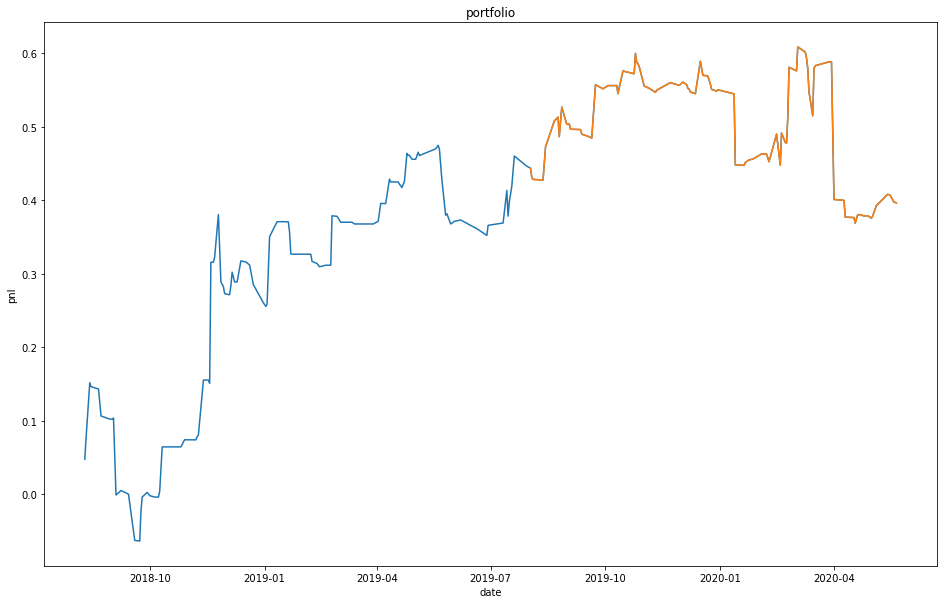

In [97]:
i = 0
strat = "gbm.crypto.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[:2])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[:2])])
min_pnl = 10
min_num = 10
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if (sum(good_strat)>0):
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# btc.usd.td train sharpe  1.8198027880938554 test sharpe  -2.6230002990048833
# eth.usd.td train sharpe  1.4028662816107922 test sharpe  0.29345145801413924
# train sharpe:  1.8074646697050671 test sharpe:  -0.5716050424660765


    

- now we can go on with rolling gbm model
- it's added this term of course

In [98]:
month = np.array([file[:7] for file in all_dates])
month_len = np.unique(month, return_counts=True)

In [100]:
## rolling model for gradient boosting machine
## returned value is the training sample standard deviation and the final model
def get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          product_list, period=4096, SAVE_PATH="e:/intern"):
    cum_daily_ticks = dict([])
    train_tick_start = dict([])
    train_tick_end = dict([])   
    test_tick_start = dict([])
    test_tick_end = dict([])
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1)
        test_tick_start[product] = int(train_tick_end[product]+2)
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1])
    coef_list = dict([])
    gb1 = GradientBoostingRegressor(random_state=0)
    gb1 = GradientBoostingRegressor(random_state=0)
    param_grid = {
            'n_estimators': np.arange(10,100,10),
            'max_depth': [3,4,5,6,7,8],
            'learning_rate':[0.01],
            'min_samples_leaf': [20], 
    }
    model = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
    train_std_mat = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in product_list:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_train = np.append(y_train, cur_y_train)
    model.fit(train_mat, y_train);
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save([train_std_mat, model], SAVE_PATH+"/model/"+strat+".pkl")
    


In [101]:
test_range = np.where(month_len[0] > "2019-08" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
cum_month_len = np.cumsum(month_len[1])

# ['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
#  '2020-04' '2020-05']




['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
 '2020-04' '2020-05']


In [102]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[:2]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [104]:
%%time
strat = "gbm.crypto.4096"
y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          product_list[:2], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# Wall time: 11min 23s


13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
Wall time: 11min 23s


- now we can generate values of each model

In [106]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    train_std_mat, model = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list[:2]:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        parLapply(CORE_NUM,all_dates[train_start:(train_end+forward_len+1)], get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=model, strat=strat_name, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
    start_month = start_month+1
    end_month = end_month+1

# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# Wall time: 11min 23s


13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
Wall time: 11min 23s


In [107]:
%%time
strat = "gbm.crypto.4096"
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    for product in product_list[0:2]:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 2019-09 2018-08-10.pkl 2019-07-30.pkl
# 2019-10 2018-09-01.pkl 2019-08-31.pkl
# 2019-11 2018-10-01.pkl 2019-09-29.pkl
# 2019-12 2018-11-06.pkl 2019-10-28.pkl
# 2020-01 2018-12-03.pkl 2019-11-29.pkl
# 2020-02 2019-01-02.pkl 2019-12-30.pkl
# 2020-03 2019-02-05.pkl 2020-01-27.pkl
# 2020-04 2019-03-03.pkl 2020-02-25.pkl
# 2020-05 2019-04-02.pkl 2020-03-30.pkl
# Wall time: 1min 10s


2019-09 2018-08-10.pkl 2019-07-30.pkl
2019-10 2018-09-01.pkl 2019-08-31.pkl
2019-11 2018-10-01.pkl 2019-09-29.pkl
2019-12 2018-11-06.pkl 2019-10-28.pkl
2020-01 2018-12-03.pkl 2019-11-29.pkl
2020-02 2019-01-02.pkl 2019-12-30.pkl
2020-03 2019-02-05.pkl 2020-01-27.pkl
2020-04 2019-03-03.pkl 2020-02-25.pkl
2020-05 2019-04-02.pkl 2020-03-30.pkl
Wall time: 1min 10s


In [108]:
def get_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2019-08")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [109]:
%%time
strat = "gbm.crypto.4096"
for product in product_list[0:2]:
    get_roll_result(product, strat, test_range, month_len, atr_filter=20)

# btc.usd.td 13 gbm.crypto.4096.2019-09
# btc.usd.td 14 gbm.crypto.4096.2019-10
# btc.usd.td 15 gbm.crypto.4096.2019-11
# btc.usd.td 16 gbm.crypto.4096.2019-12
# btc.usd.td 17 gbm.crypto.4096.2020-01
# btc.usd.td 18 gbm.crypto.4096.2020-02
# btc.usd.td 19 gbm.crypto.4096.2020-03
# btc.usd.td 20 gbm.crypto.4096.2020-04
# btc.usd.td 21 gbm.crypto.4096.2020-05
# eth.usd.td 13 gbm.crypto.4096.2019-09
# eth.usd.td 14 gbm.crypto.4096.2019-10
# eth.usd.td 15 gbm.crypto.4096.2019-11
# eth.usd.td 16 gbm.crypto.4096.2019-12
# eth.usd.td 17 gbm.crypto.4096.2020-01
# eth.usd.td 18 gbm.crypto.4096.2020-02
# eth.usd.td 19 gbm.crypto.4096.2020-03
# eth.usd.td 20 gbm.crypto.4096.2020-04
# eth.usd.td 21 gbm.crypto.4096.2020-05
# Wall time: 47min 26s


btc.usd.td 13 gbm.crypto.4096.2019-09
btc.usd.td 14 gbm.crypto.4096.2019-10
btc.usd.td 15 gbm.crypto.4096.2019-11
btc.usd.td 16 gbm.crypto.4096.2019-12
btc.usd.td 17 gbm.crypto.4096.2020-01
btc.usd.td 18 gbm.crypto.4096.2020-02
btc.usd.td 19 gbm.crypto.4096.2020-03
btc.usd.td 20 gbm.crypto.4096.2020-04
btc.usd.td 21 gbm.crypto.4096.2020-05
eth.usd.td 13 gbm.crypto.4096.2019-09
eth.usd.td 14 gbm.crypto.4096.2019-10
eth.usd.td 15 gbm.crypto.4096.2019-11
eth.usd.td 16 gbm.crypto.4096.2019-12
eth.usd.td 17 gbm.crypto.4096.2020-01
eth.usd.td 18 gbm.crypto.4096.2020-02
eth.usd.td 19 gbm.crypto.4096.2020-03
eth.usd.td 20 gbm.crypto.4096.2020-04
eth.usd.td 21 gbm.crypto.4096.2020-05
Wall time: 47min 26s


sharpe  0.414375642295953


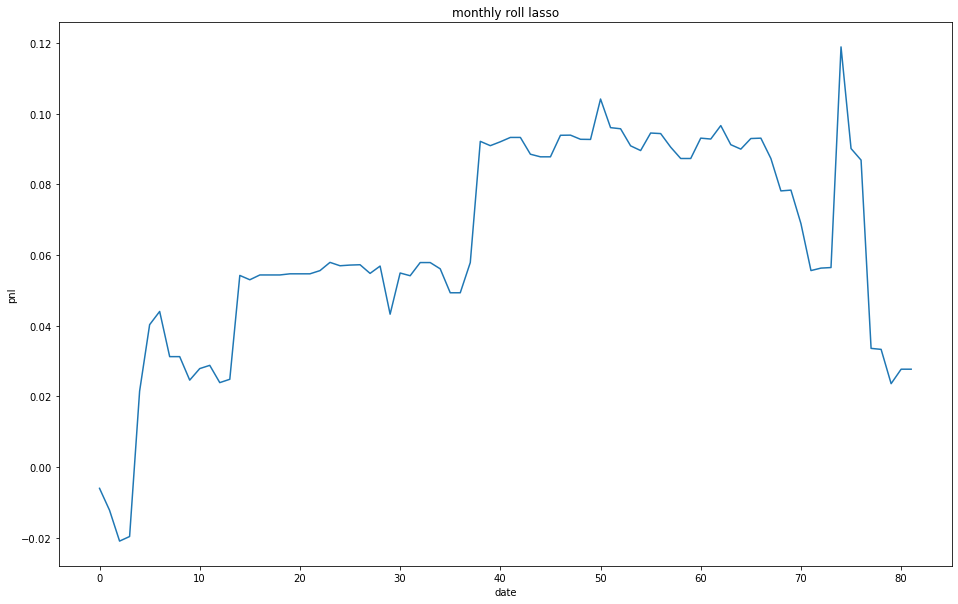

In [112]:
n_product = len(product_list[0:2])
save_path = "signal result atr"
strat = "gbm.crypto.4096"
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>10*spread)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    #avg_test_pnl = test_mat.mean(axis=1)
    avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  0.414375642295953



- Now let's start with xgboost

In [113]:
import xgboost as xgb

- we need to create specific train and test data sets for xgboost

In [114]:
cv_params = {'max_depth': [3,4,5,6,7,8,9,10], 
             'n_estimators': np.arange(10,200,10)}
ind_params = {'learning_rate': 0.1,
              "min_samples_leaf":[10,20],
              'seed':100, 'objective': 'reg:linear'}
xgb_cv = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                            cv = 5, n_jobs = -1) 

In [115]:
%%time
xgb_cv.fit(x_train, y_train);

# Wall time: 8min 24s

# GridSearchCV(cv=5, error_score='raise-deprecating',
#              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
#                                     colsample_bylevel=1, colsample_bytree=1,
#                                     gamma=0, importance_type='gain',
#                                     learning_rate=0.1, max_delta_step=0,
#                                     max_depth=3, min_child_weight=1,
#                                     min_samples_leaf=[10, 20], missing=None,
#                                     n_estimators=100, n_jobs=1, nthread=None,
#                                     objective='reg:linear', random_state=0,
#                                     reg_alpha=0, reg_lambda=1,
#                                     scale_pos_weight=1, seed=100, silent=True,
#                                     subsample=1),
#              iid='warn', n_jobs=-1,
#              param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#                          'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
#        140, 150, 160, 170, 180, 190])},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#              scoring=None, verbose=0)

Wall time: 8min 24s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    min_samples_leaf=[10, 20], missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=100, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': array([ 10,  20,  30,  40

In [116]:
#best_parameters, score, _ = max(xgb_cv.grid_scorer, key=lambda x: x[1])
xgb_cv.best_params_
## {'max_depth': 3, 'n_estimators': 40}

{'max_depth': 3, 'n_estimators': 40}

In [117]:
strat = "xgb.crypto.4096"
signal_name = strat

In [118]:
SAVE_PATH = "e:/intern"
for product in product_list[0:2]:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)


- we can plot them to check the result

In [119]:
%%time
for product in product_list[0:2]:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=xgb_cv, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 1min 59s


Wall time: 1min 59s


''

In [120]:
%%time
for product in product_list[0:2]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")
    
#  Wall time: 12.3 s


Wall time: 12.3 s


In [122]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("xgb.crypto", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 9min 38s



reverse=1
reverse=1
Wall time: 9min 38s


btc.usd.td train sharpe  2.87537796788086 test sharpe  -0.41319254807169187
eth.usd.td train sharpe  1.2929395452179817 test sharpe  0.42662596786220847
train sharpe:  2.3421564454152226 test sharpe:  0.0010513385244776202


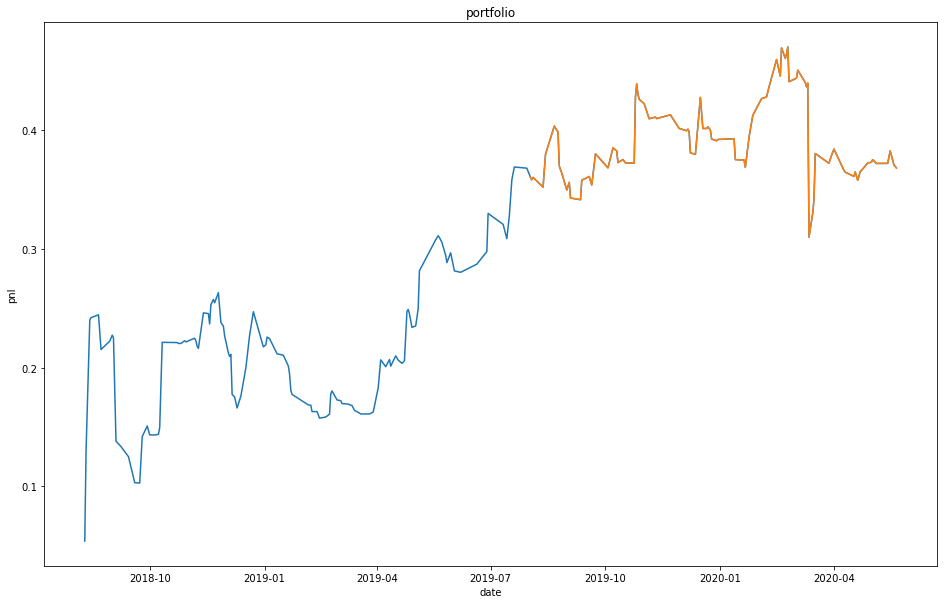

In [124]:
i = 0
strat = "xgb.crypto.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[0:2])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[0:2])])
min_pnl = 2
min_num = 10
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)>0:
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
    else:
        train_pnl = np.zeros(np.shape(train_stat["daily.ret"])[0])
        test_stat = signal_stat["test.stat"]
        test_pnl = np.zeros(np.shape(test_stat["daily.ret"])[0])
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# btc.usd.td train sharpe  2.87537796788086 test sharpe  -0.41319254807169187
# eth.usd.td train sharpe  1.2929395452179817 test sharpe  0.42662596786220847
# train sharpe:  2.3421564454152226 test sharpe:  0.0010513385244776202



- SUMMARY


- today we compare two tree-based models: gradient boosting machine and xgboost
- but the result is pretty bad
- you can try to tune the parameter to see whether we could improve it